In [3]:
import pandas as pd
from nltk.tokenize import word_tokenize,RegexpTokenizer
import nltk
from nltk.corpus import stopwords,wordnet
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import numpy as np

from bert_sklearn import BertClassifier
from bert_sklearn import BertRegressor
from bert_sklearn import BertTokenClassifier
from bert_sklearn import load_model

In [43]:
!pip install bert_sklearn

In [2]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .
import os
os.chdir("bert-sklearn")
print(os.listdir())

Cloning into 'bert-sklearn'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 516.15 KiB | 1.66 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /content/bert-sklearn
     |████████████████████████████████| 133kB 8.2MB/s 
     |████████████████████████████████| 81kB 10.9MB/s 
     |████████████████████████████████| 7.6MB 20.2MB/s 
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-cp37-none-any.whl size=54235 sha256=883b55a16b5049d1a0a6fac232dc2690825febde8b74a377ecbf95b0f83e42e4
  Stored in directory: /root/.cache/pip/wheels/61/95/c6/5790aae8fb377f5ff356dbe58205aab28858595d6bff8197d0
Successfully built bert-sklearn
ERROR: botocore 1.20.85 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.
['setup.py', 'glue_examples', '.git', 'tests', 'demo.ipynb', 'bert_sklearn', 'Options.md', 'other_examples', 'demo_tuning_hyperparams.ipynb'

In [7]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
data=pd.read_csv("/content/drive/MyDrive/train_2kmZucJ.csv")
data

,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...
...,...,...,...
7915,7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7916,7917,0,We would like to wish you an amazing day! Make...
7917,7918,0,Helping my lovely 90 year old neighbor with he...
7918,7919,0,Finally got my #smart #pocket #wifi stay conne...


In [ ]:
data['tweet'][0]

'#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone'

### stopword removal

In [5]:
re=RegexpTokenizer('[a-zA-Z]+')


In [8]:
sw=list(stopwords.words('english'))
sw.append('http')
sw.append('https')
sw.append('com')


In [9]:
def remove_stopwords(text):
  new_text=[word for word in text if word.lower() not in sw and len(word)>1]
  return new_text

In [10]:
def clean_data(data):
    data=[re.tokenize(sent) for sent in data]
    data=[remove_stopwords(sent) for sent in data]
    return data

In [11]:
data['tweet']=clean_data(data['tweet'])
data=data.drop(columns=['id'])

# Lemmatization

In [13]:
lemmatizer=WordNetLemmatizer()

In [14]:
def get_pos_tag(tag):
    if tag.startswith('J'):
      return wordnet.ADJ
    elif tag.startswith('V'):
         return wordnet.VERB 
    elif tag.startswith('N'):
         return wordnet.NOUN 
    elif tag.startswith('R'):
         return wordnet.ADV
    else:
         return wordnet.NOUN                 

In [15]:
def clean_text(text):
  output=[]
  for w in text:
    pos=pos_tag(w)
    clean=lemmatizer.lemmatize(w,get_pos_tag(pos[0][1]))
    output.append(clean)
  return output  
  

In [16]:
data['tweet']=[clean_text(sent) for sent in data['tweet']]

In [19]:
x_train=data['tweet']
y_train=data['label']

# TEXT TO FEATURES

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv=CountVectorizer()

In [ ]:
vectorized=cv.fit_transform(data['tweet'])

In [ ]:
vectorized

<7920x22015 sparse matrix of type '<class 'numpy.int64'>'
	with 105363 stored elements in Compressed Sparse Row format>

# Bag of Words

In [ ]:
def all_words(data):
  bag_of_words=[]
  for sent in data:
    for w in sent:
      bag_of_words.append(w)
  return bag_of_words    

In [ ]:
clean_words=all_words(data['tweet'])

In [ ]:
len(clean_words)

108933

In [ ]:
count=nltk.FreqDist(clean_words)

In [ ]:
features=count.most_common(100)

In [ ]:
feature=[i[0] for i in features]

In [ ]:
def get_feature_dict(data):
  current_features={}
  word_set=set(data)
  for w in feature:
    current_features[w]=w in word_set
  return list(current_features.values())  

In [ ]:
training_data=[get_feature_dict(text) for text in data['tweet']]

In [ ]:
y_train=data['label'].values

In [ ]:
train=np.array(training_data)


# Neural Network

In [ ]:
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

In [ ]:
model=Sequential()
model.add(Dense(256,activation='relu',input_dim=100))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,'relu'))
model.add(Dense(128,'relu'))
model.add(Dropout(0.3))
model.add(Dense(16,'relu'))
model.add(Dense(1,'sigmoid'))
model.summary()
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [ ]:

hist=model.fit(train,y_train,epochs=20,validation_split=0.1)

In [ ]:
from matplotlib import pyplot as plt

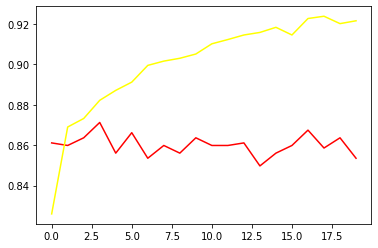

In [ ]:
plt.plot(hist.history['val_acc'],color='red')
plt.plot(hist.history['acc'],color='yellow')
plt.show()

In [ ]:
preds=model.predict(testing_data)

In [ ]:
for i in range(len(preds)):
  if preds[i]<0.5:
     preds[i]=int(0)
  else:
    preds[i]=int(1)   

In [ ]:
preds=preds.astype('int32')

In [ ]:
np.count_nonzero(preds)

574

## BERT SKLEARN

In [21]:
model=BertClassifier(epochs=3)

Building sklearn text classifier...


In [22]:
model.fit(x_train,y_train)

Loading bert-base-uncased model...
Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 7128, validation data size: 792



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))




Epoch 1, Train loss: 0.2872, Val loss: 0.2540, Val accy: 89.39%





Epoch 2, Train loss: 0.1858, Val loss: 0.2355, Val accy: 90.15%





Epoch 3, Train loss: 0.1325, Val loss: 0.2663, Val accy: 90.15%



BertClassifier(bert_config_json=None, bert_model='bert-base-uncased',
               bert_vocab=None, do_lower_case=True, epochs=3, eval_batch_size=8,
               fp16=False, from_tf=False, gradient_accumulation_steps=1,
               ignore_label=None, label_list=array([0, 1]), learning_rate=2e-05,
               local_rank=-1, logfile='bert_sklearn.log', loss_scale=0,
               max_seq_length=128, num_mlp_hiddens=500, num_mlp_layers=0,
               random_state=42, restore_file=None, train_batch_size=32,
               use_cuda=True, validation_fraction=0.1, warmup_proportion=0.1)

In [30]:
x_test=pd.read_csv('/content/drive/MyDrive/test_oJQbWVk.csv')

In [31]:
df=pd.DataFrame()

In [32]:
df['id']=x_test['id']

In [33]:
x_test=x_test.drop(columns=['id'])

In [35]:
x_test['tweet']=clean_data(x_test['tweet'])

In [38]:
x_test['tweet']=[clean_text(sent) for sent in x_test['tweet']]

In [46]:
x_test=x_test['tweet']

In [48]:
preds=model.predict(x_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [50]:
df['label']=preds

In [55]:
fd=df.to_csv('/content/drive/MyDrive/AV dataset/avans.csv',index=False)

In [54]:
df

,id,label
0,7921,1
1,7922,1
2,7923,1
3,7924,1
4,7925,1
...,...,...
1948,9869,1
1949,9870,0
1950,9871,1
1951,9872,1
